# Курсовая работа № 2
## Аналитика. Начальный уровень

Курсовая работа состоит из двух частей – обязательной и дополнительной. **Для зачета необходимо выполнение только первой части.** Выполнение второй части может потребовать дополнительные знания Python.

- [Часть первая](#Часть-первая)
- [Часть вторая](#Часть-вторая)

## Часть первая


Перед вами стоит задача – подготовить аналитический отчет для HR-отдела. На основании проведенной аналитики предполагается составить рекомендации для отдела кадров по стратегии набора персонала, а также по взаимодействию с уже имеющимися сотрудниками.
<br><br> В базе данных лежит набор таблиц, которые содержат данные о сотрудниках вымышленной компании.
Сделайте обзор штата сотрудников компании. Составьте набор предметов исследования, а затем проверьте их на данных. Вся аналитика должна быть выполена с помощью SQL. Впоследствии данные можно визуализировать, однако финальные датафреймы для графиков также должны быть подготовлены с помощью SQL. <br><br>

Примеры гипотез:
1. Есть зависимость между `perfomance score` и тем, под чьим руководством работает сотрудник.
2. Есть зависимость между продолжительностью работы в компании и семейным положением сотрудника.
2. Есть зависимость между продолжительностью работы в компании и возрастом сотрудника.

<br><br>
Параметры для подключения следующие: хост – `dsstudents.skillbox.ru`, порт – `5432`, имя базы данных – `human_resources`, пользователь – `readonly`, пароль – `6hajV34RTQfmxhS`. Таблицы, доступные для анализа, – `hr_dataset`, `production_staff`, `recruiting_costs`, `salary_grid`.

In [2]:
### YOUR CODE HERE ###
import psycopg2
import pandas as pd

conn=psycopg2.connect(host='dsstudents.skillbox.ru',
                     port=int(5432),
                     user='readonly',
                     password='6hajV34RTQfmxhS',
                     database='human_resources')

hr_dataset=pd.read_sql_query("SELECT * FROM hr_dataset ",conn)
production_staff=pd.read_sql_query("SELECT * FROM production_staff ",conn)
recruiting_costs=pd.read_sql_query("SELECT * FROM recruiting_costs ",conn)
salary_grid=pd.read_sql_query("SELECT * FROM salary_grid ",conn)

In [4]:
print(hr_dataset[['maritalstatusid','maritaldesc']])


     maritalstatusid maritaldesc
0                  1     Married
1                  2    Divorced
2                  0      Single
3                  1     Married
4                  0      Single
..               ...         ...
305                0      Single
306                0      Single
307                0      Single
308                1     Married
309                1     Married

[310 rows x 2 columns]


##### Есть зависимость между perfomance score и тем, под чьим руководством работает сотрудник

In [2]:
pd.read_sql('''SELECT DISTINCT "Performance Score" 
                FROM production_staff
                WHERE "Performance Score" is not Null''',conn)

,Performance Score
0,Exceptional
1,90-day meets
2,N/A- too early to review
3,Fully Meets
4,Exceeds
5,PIP
6,Needs Improvement


In [3]:
pd.read_sql('''SELECT DISTINCT "Manager Name", 
/*
дальнейшие селекты работают по выбранному Manager Name (запрос с доп условием)
изначально выбрал все возможные варианты Performance Score (запрос выше), 
далее сделал много select для каждого уникального значения, чтобы было легче читать таблицу
*/
                (SELECT COUNT(B."Performance Score")
                                FROM production_staff B
                                WHERE B."Manager Name" = A."Manager Name" and 
                                B."Performance Score" = 'Exceptional') as "Exceptional", 
                (SELECT COUNT(B."Performance Score")
                                FROM production_staff B
                                WHERE B."Manager Name" = A."Manager Name" and 
                                B."Performance Score" = '90-day meets') as "90-day meets", 
                (SELECT COUNT(B."Performance Score")
                                FROM production_staff B
                                WHERE B."Manager Name" = A."Manager Name" and 
                                B."Performance Score" = 'N/A- too early to review') as "N/A- too early to review", 
                (SELECT COUNT(B."Performance Score")
                                FROM production_staff B
                                WHERE B."Manager Name" = A."Manager Name" and 
                                B."Performance Score" = 'Fully Meets') as "Fully Meets", 
                (SELECT COUNT(B."Performance Score")
                                FROM production_staff B
                                WHERE B."Manager Name" = A."Manager Name" and 
                                B."Performance Score" = 'Exceeds') as "Exceeds", 
                (SELECT COUNT(B."Performance Score")
                                FROM production_staff B
                                WHERE B."Manager Name" = A."Manager Name" and 
                                B."Performance Score" = 'PIP') as "PIP", 
                (SELECT COUNT(B."Performance Score")
                                FROM production_staff B
                                WHERE B."Manager Name" = A."Manager Name" and 
                                B."Performance Score" = 'Needs Improvement') as "Needs Improvement", 
                (SELECT COUNT(B."Performance Score")
                                FROM production_staff B
                                WHERE B."Manager Name" = A."Manager Name") as "Sum"
                FROM production_staff A
                WHERE "Manager Name" is not Null''',
            conn)

,Manager Name,Exceptional,90-day meets,N/A- too early to review,Fully Meets,Exceeds,PIP,Needs Improvement,Sum
0,Amy Dunn,1,1,5,11,2,1,0,21
1,Brannon Miller,2,1,0,8,5,4,1,21
2,David Stanley,0,1,4,15,1,0,0,21
3,Elijiah Gray,0,3,3,14,2,0,1,23
4,Elisa Bramante,0,0,0,10,2,0,2,14
5,Kelley Spirea,0,3,1,15,3,0,0,22
6,Ketsia Liebig,0,2,2,14,2,0,1,21
7,Kissy Sullivan,1,3,1,14,1,1,1,22
8,Michael Albert,0,1,6,10,2,1,3,23
9,Webster Butler,0,3,3,11,2,0,2,21


Не считая Elisa Bramante, у всех менеджеров примерно одинаковое количество подчиненных. У Brannon Miller больше всего сотрудников, качество работы которых превышает (Exceptional и Exceeds). У Michael Albert показатели сотрудников хуже всех (больше всех Needs Improvement, Fully Meets меньше всех, мало Exceeds и нет Exceptional). Отметим, что у него много сотрудников без оценок (N/A- too early to review). Возможно стоит дождаться их оценок и уже принимать какие-либо решения. 

##### Есть зависимость между продолжительностью работы в компании и семейным положением сотрудника

In [3]:
pd.read_sql(''' SELECT DISTINCT "maritaldesc" as Description,
/*
дальнейшие селекты работают по выбранному maritalstatusid (запрос с доп условием)
*/
                    (SELECT cast(avg(B."Days Employed") as int)
                    FROM hr_dataset B
                    WHERE B."maritalstatusid"=A."maritalstatusid") as "Average", 
                    (SELECT cast(sum(B."Days Employed") as int)
                    FROM hr_dataset B
                    WHERE B."maritalstatusid"=A."maritalstatusid") as "Sum", 
                    (SELECT count(B."Days Employed")
                    FROM hr_dataset B
                    WHERE B."maritalstatusid"=A."maritalstatusid") as "Number of workers"
                FROM hr_dataset A
                WHERE "maritalstatusid" is not Null''',conn) # оцениваем по тем, по кому данные "не битые"

,description,Average,Sum,Number of workers
0,Divorced,1103,33086,30
1,Married,1246,153287,123
2,Separated,1703,20441,12
3,Single,1373,188067,137
4,Widowed,863,6904,8


Вопросы по статистике: как правится статистика, когда человек переходит из одной категории в другую. Предположим человек женился, его счетчик обнуляется. Пусть он работал 1000 дней, потом женился. 1000 дней идут в статистику как одиночки и новый отсчет для строчки женатого человека, или будет что-то типа 1005 дней работает человек в браке? Автору скрипта перед аналитикой надо задать такой вопрос. Дальше только по цифрам что есть.
Вдовы/вдовцы меньше работают в компании. Либо сказывается возраст (обычно овдовевшими становятся ближе к старости) и отправляются на пенсию (тут прям мощный щелчок, что и сам скоро уйдешь), либо они решаются координально изменить жизнь, коли изменения уже сами пошли. Одиночки работают больше в компании (кроме separated, что это?). Одиночки обычно молодые (чем старше, тем больше вероятность быть в других группах). Есть предположение, что компания в основном из молодых людей. Значит лучше в эту компанию также нанимать молодых, проще коллективу будет сплотиться, и разных полов, чтобы сплотиться еще сильнее. Разведенные люди работают меньше чем женатые, видимо, тоже решают кардинально менять жить (раньше с такой зп нормально, партнер помогал, а теперь не хватает, больше платите или ухожу).

##### Зависимость между способом найма (и стоимостью такого найма) к количеству сотрудников и их суммарной зп.

In [4]:
third_task = pd.read_sql(''' SELECT A."Employment Source", A."Total",
/*
дальнейшие селекты работают по выбранному A."Employment Source" (запрос с доп условием)
*/
                (SELECT count(hr_dataset."Employee Source") 
                    FROM recruiting_costs B
                    JOIN hr_dataset on hr_dataset."Employee Source"=B."Employment Source"
                    WHERE B."Employment Source"=A."Employment Source" and
                    hr_dataset."Employment Status"='Active') as "Number of current workers",
                (SELECT CAST(A."Total" as int) / NULLIF(count(hr_dataset."Employee Source"), 0)
                    FROM recruiting_costs B
                    JOIN hr_dataset on hr_dataset."Employee Source"=B."Employment Source"
                    WHERE B."Employment Source"=A."Employment Source" and
                    hr_dataset."Employment Status"='Active') as "Cost of one employee",
/*
Считаю их суммарную зп для сотрудников на найденных позициях для каждого метода и делил на кол-во сотрудников так найденных
NULLIF для случая деления на 0 (исключить ошибку SQL)
"(SELECT count(hr_dataset."Employee Source")..." использовал, чтобы снова использовать величину количества сотрудников
*/
                (SELECT cast(sum(salary_grid."Salary Mid") as int) / NULLIF((SELECT count(hr_dataset."Employee Source")
                                                                                FROM recruiting_costs B
                                                                                JOIN hr_dataset on hr_dataset."Employee Source"=B."Employment Source"
                                                                                WHERE B."Employment Source"=A."Employment Source" and
                                                                                hr_dataset."Employment Status"='Active'), 0)
                    FROM recruiting_costs B
                    JOIN hr_dataset on hr_dataset."Employee Source"=B."Employment Source"
                    JOIN salary_grid on salary_grid."Position"=hr_dataset."position"
                    WHERE B."Employment Source"=A."Employment Source" and
                    hr_dataset."Employment Status"='Active') as "Average salary of one worker"
                FROM recruiting_costs A''',conn)
third_task

,Employment Source,Total,Number of current workers,Cost of one employee,Average salary of one worker
0,Billboard,6192,11,562.0,29818.0
1,Careerbuilder,7790,1,7790.0,48000.0
2,Company Intranet - Partner,0,0,NaN,NaN
3,Diversity Job Fair,10021,9,1113.0,30746.0
4,Employee Referral,0,24,0.0,45362.0
5,Glassdoor,0,7,0.0,44450.0
6,Information Session,0,2,0.0,33425.0
7,Internet Search,0,4,0.0,22856.0
8,MBTA ads,10980,12,915.0,34666.0
9,Monster.com,5760,13,443.0,24834.0


Самым эффективным методом найма был Employee Referral (узнать бы сколько платили действующему сотруднику за приведенного нового, чтобы внести в таблицу). Самым дорогим способом оказался поиск Careerbuilder, дальше Social Networks - Facebook Twitter etc, однако такие сотрудники достаточно много зарабатывают суммарно (что говорит о важности этих сотрудников). Такие способы как Billboard, Website Banner Ads и Monster.com привели много сотрудников, но их суммарная зп не слишком велика. Internet Search, видимо, помогает найти только низкоспециализированных сотрудников (низкая средняя зп), поиск условно бесплатный (не знаем сколько hr искал в часах этих сотрудников). Pay Per Click - Google по поиску и качеству нанимаемых сотрудников похож на Internet Search. Выгодным оказался Newspager/Magazine

<ipython-input-5-093e41115d33>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  third_task.dropna()[third_task['Total'] != 0].plot(x='Cost of one employee',


<AxesSubplot:title={'center':'ЗП сотрудника как стоимость его найма'}, xlabel='Cost of one employee', ylabel='Average salary of one worker'>

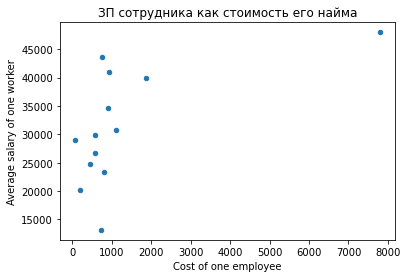

In [5]:
third_task.dropna()[third_task['Total'] != 0].plot(x='Cost of one employee', 
                                                   y='Average salary of one worker', 
                                                   kind='scatter',
                                                  title='ЗП сотрудника как стоимость его найма')

Идеальными способами поиска сотрудников будут те, чьи координаты в левом верхнем углу т.к. низкая стоимость за поиск одного сотрудника и высокая зп самого сотрудника (что говорит о его важности). Не считаю тех, у кого нет данных о стоимости поиска (как On-line Web application). "В самом углу" нет точек, он окружен из чуть более дорогих способов, но важных сотрудников (идти вправо, методы Newspager/Magazine и On-campus Recruiting) и дешевых способов, но не сильно высокие должности (идти вниз, методы Professional Society и Billboard).